In [12]:
NORMAL_DRIVING_PATH = './data2/normal/'
CORRECTIN_DRIVING_PATH = './data2/correcting/'
REVERSE_DRIVING_PATH = './data2/reverse/'

In [29]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_lines(path):
    lines = []
    with open ('%sdriving_log.csv' % path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        return lines


normal_lines = get_lines(NORMAL_DRIVING_PATH)
correction_lines = get_lines(CORRECTIN_DRIVING_PATH)
reverse_lines = get_lines(REVERSE_DRIVING_PATH)
print(normal_lines[0][0].split('/')[-1])
print(correction_lines[0][0].split('/')[-1])
print(reverse_lines[0][0].split('/')[-1])



center_2017_10_24_17_22_37_747.jpg
center_2017_10_24_17_35_52_913.jpg
center_2017_10_24_17_27_05_890.jpg


In [22]:
def load_image(img_full_path):
    # Name of the img, e.g. center_2017_10_24_17_22_37_747.jpg
    name = img_full_path.split('/')[-1]

    # Mode, i.e. normal, correcting, reverse
    dataset = img_full_path.split('/')[-3]

    path = './data2/%s/IMG/%s' % (dataset, name)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

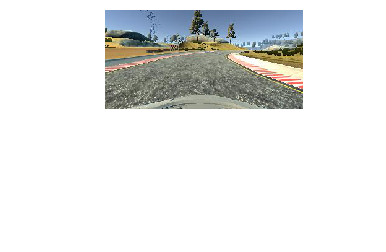

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(reverse_lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

In [31]:
import sklearn.utils

CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.2
RIGHT_ANGLE_CORRECTION = -0.2

def generator(data, batch_size=128):
    num_samples = len(data)
    while True:
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_img = load_image(batch_sample[CENTER])
                left_img = load_image(batch_sample[LEFT])
                right_img = load_image(batch_sample[RIGHT])
                angle = float(batch_sample[ANGLE])
                
                images.append(center_img)
                angles.append(angle)
                images.append(cv2.flip(center_img, 1))
                angles.append(angle * -1)
                
                
                images.append(left_img)
                angles.append(angle + LEFT_ANGLE_CORRECTION)
                images.append(cv2.flip(left_img, 1))
                angles.append((angle + LEFT_ANGLE_CORRECTION) * -1)
                
                images.append(right_img)
                angles.append(angle + RIGHT_ANGLE_CORRECTION)
                images.append(cv2.flip(right_img, 1))
                angles.append((angle + RIGHT_ANGLE_CORRECTION) * -1)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [23]:
from sklearn.model_selection import train_test_split

# Combine all the data lines together.
all_lines = normal_lines + correction_lines + reverse_lines

train_samples, validation_samples = train_test_split(all_lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

In [24]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
#model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# Resize the image to match the nvidia sizes.
model.add(Lambda(resize, input_shape=(160, 320, 3)))

# Normalize the image.
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv4', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv5', activation='elu'))

model.add(Flatten())
#model.add(Dense(1, activation='elu'))

model.summary()

model.add(Dense(1164, name='desn1164', activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, name='dense100'))
model.add(Dropout(0.5))
model.add(Dense(50, name='dense50'))
model.add(Dropout(0.5))
model.add(Dense(10, name='dense10'))
model.add(Dense(1, name='dense1'))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples * 3),    # * 6 for center, left, and right image
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples * 3),  # * 6 for center, left, and right image
    nb_epoch=10)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_9 (Lambda)                (None, 66, 200, 3)    0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
lambda_10 (Lambda)               (None, 66, 200, 3)    0           lambda_9[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_10[0][0]                  
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 14, 47, 36)    21636       conv1[0][0]                      
___________________________________________________________________________________________